In [1]:
import numpy as np 
import pandas as pd
import os 
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RandomizedSearchCV
from xgboost.sklearn import XGBRegressor
from sklearn.feature_selection import SelectFromModel

from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

In [6]:
def param_randomizedtune_pipline(model, X_train, X_test, y_train, y_test, param_grid, plot_flag = True):

    rs_clf = RandomizedSearchCV(model, 
    param_grid, 
    n_iter=10, 
    n_jobs = 8,
    cv = 10,
    scoring='median_absolute_error',
    refit = True, 
    random_state = 10086, verbose = 0)

    rs_clf.fit(X_train, y_train)

    score = rs_clf.best_score_
    param_recommend = rs_clf.best_params_

    train_pred = rs_clf.predict(X_train)
    train_pred = train_pred.reshape(y_train.shape)
    test_pred = rs_clf.predict(X_test)
    test_pred = test_pred.reshape(y_test.shape)

    print('Training Median Absolute Error Ratio %.2f'%(100*np.divide(np.abs(train_pred - y_train),y_train).mean()))
    print('Testing Median Absolute Error Ratio %.2f'%(100*np.divide(np.abs(test_pred - y_test),y_test).mean()))


    if plot_flag:
        fig, ax = plt.subplots(figsize=(8,6), dpi=500)

        ax.scatter(y_train, train_pred, color = 'blue', label = 'Train')
        ax.scatter(y_test, test_pred, color = 'red', label = 'Test')
        plt.xlabel('Actual Ratio')
        plt.ylabel('Predicted Ratio')
        plt.legend()
        font = {'fontname':'Times New Roman', 'size' : 20}

        ax.tick_params(axis="y",direction="in")
        ax.tick_params(axis="x",direction="in")
        # plt.plot([y_train.min(), y_train.max()],[y_train.min(), y_train.max()], color = 'black', linewidth = 2)
        plt.xlim([0.9,2.4])
        plt.xticks( fontname = 'Times New Roman', fontsize = 18)
        plt.ylim([0.9,2.4])
        plt.yticks(fontname = 'Times New Roman', fontsize = 18)
        plt.xlabel('Actual $CMR_{retrof} / CMR_{exist}$', **font)
        plt.ylabel('Predicted $CMR_{retrof} / CMR_{exist}$', **font)
        plt.locator_params(axis='y', nbins=6)
        plt.locator_params(axis='x', nbins=6)
        plt.legend(frameon = False, prop =  {"family":'Times New Roman', "size":18})
        plt.plot([1,6],[1,6],'--', linewidth = 2, color = 'black')
        sns.despine()

    return rs_clf

In [3]:
param_grid = {'num_feature':[5,10,15,20],
'eta':[0.01,0.015,0.02,0.025,0.05,0.1,0.5,1.0],
'gamma':[0, 0.001,0.01,0.015,0.02,0.025,0.03,0.05,0.1,0.5],
'max_depth':[100,200,300,400,500,600,700,800,1000,2000],
'subsample':[0.1,0.2,0.3,0.4,0.5,0.8,1],
'lambda':[0,0.1,0.2,0.3,0.4,0.5,0.8,1.0],
'alpha':[0,0.1,0.2,0.3,0.4,0.5,0.8,1.0]}

# Retrofitted Building Model

In [4]:
os.chdir(r'C:\Users\User\Desktop\FinalOptimization\XGBoostPipline')
# Read in data
Retrofit_TrainTest_DesignMatrix = pd.read_csv(r'RetrofitDsMedianRatio\RetrofitRatioTrainTestMatrix_Updated.csv')
Retrofit_Edge_DesignMatrix = pd.read_csv(r'RetrofitDsMedianRatio\RetrofitRatioEdgeMatrix.csv')
# Retrofit_Verification_DesignMatrix = pd.read_csv(r'RetrofitDsMedianRatio\RetrofitRatioVerificationMatrix.csv')

Retrofit_TrainTestDSMedian_Ratio = pd.read_csv('RetrofitDsMedianRatio\DSMedianRatio_TrainTest_Updated.csv')
Retrofit_EdgeDSMedian_Ratio = pd.read_csv('RetrofitDsMedianRatio\DSMedianRatio_Edge.csv')
# Retrofit_VerificationDSMedian_Ratio = pd.read_csv('RetrofitDsMedianRatio\DSMedianRatio_Verification.csv')

[10:54:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Median Absolute Error Ratio 1.31
Testing Median Absolute Error Ratio 2.67


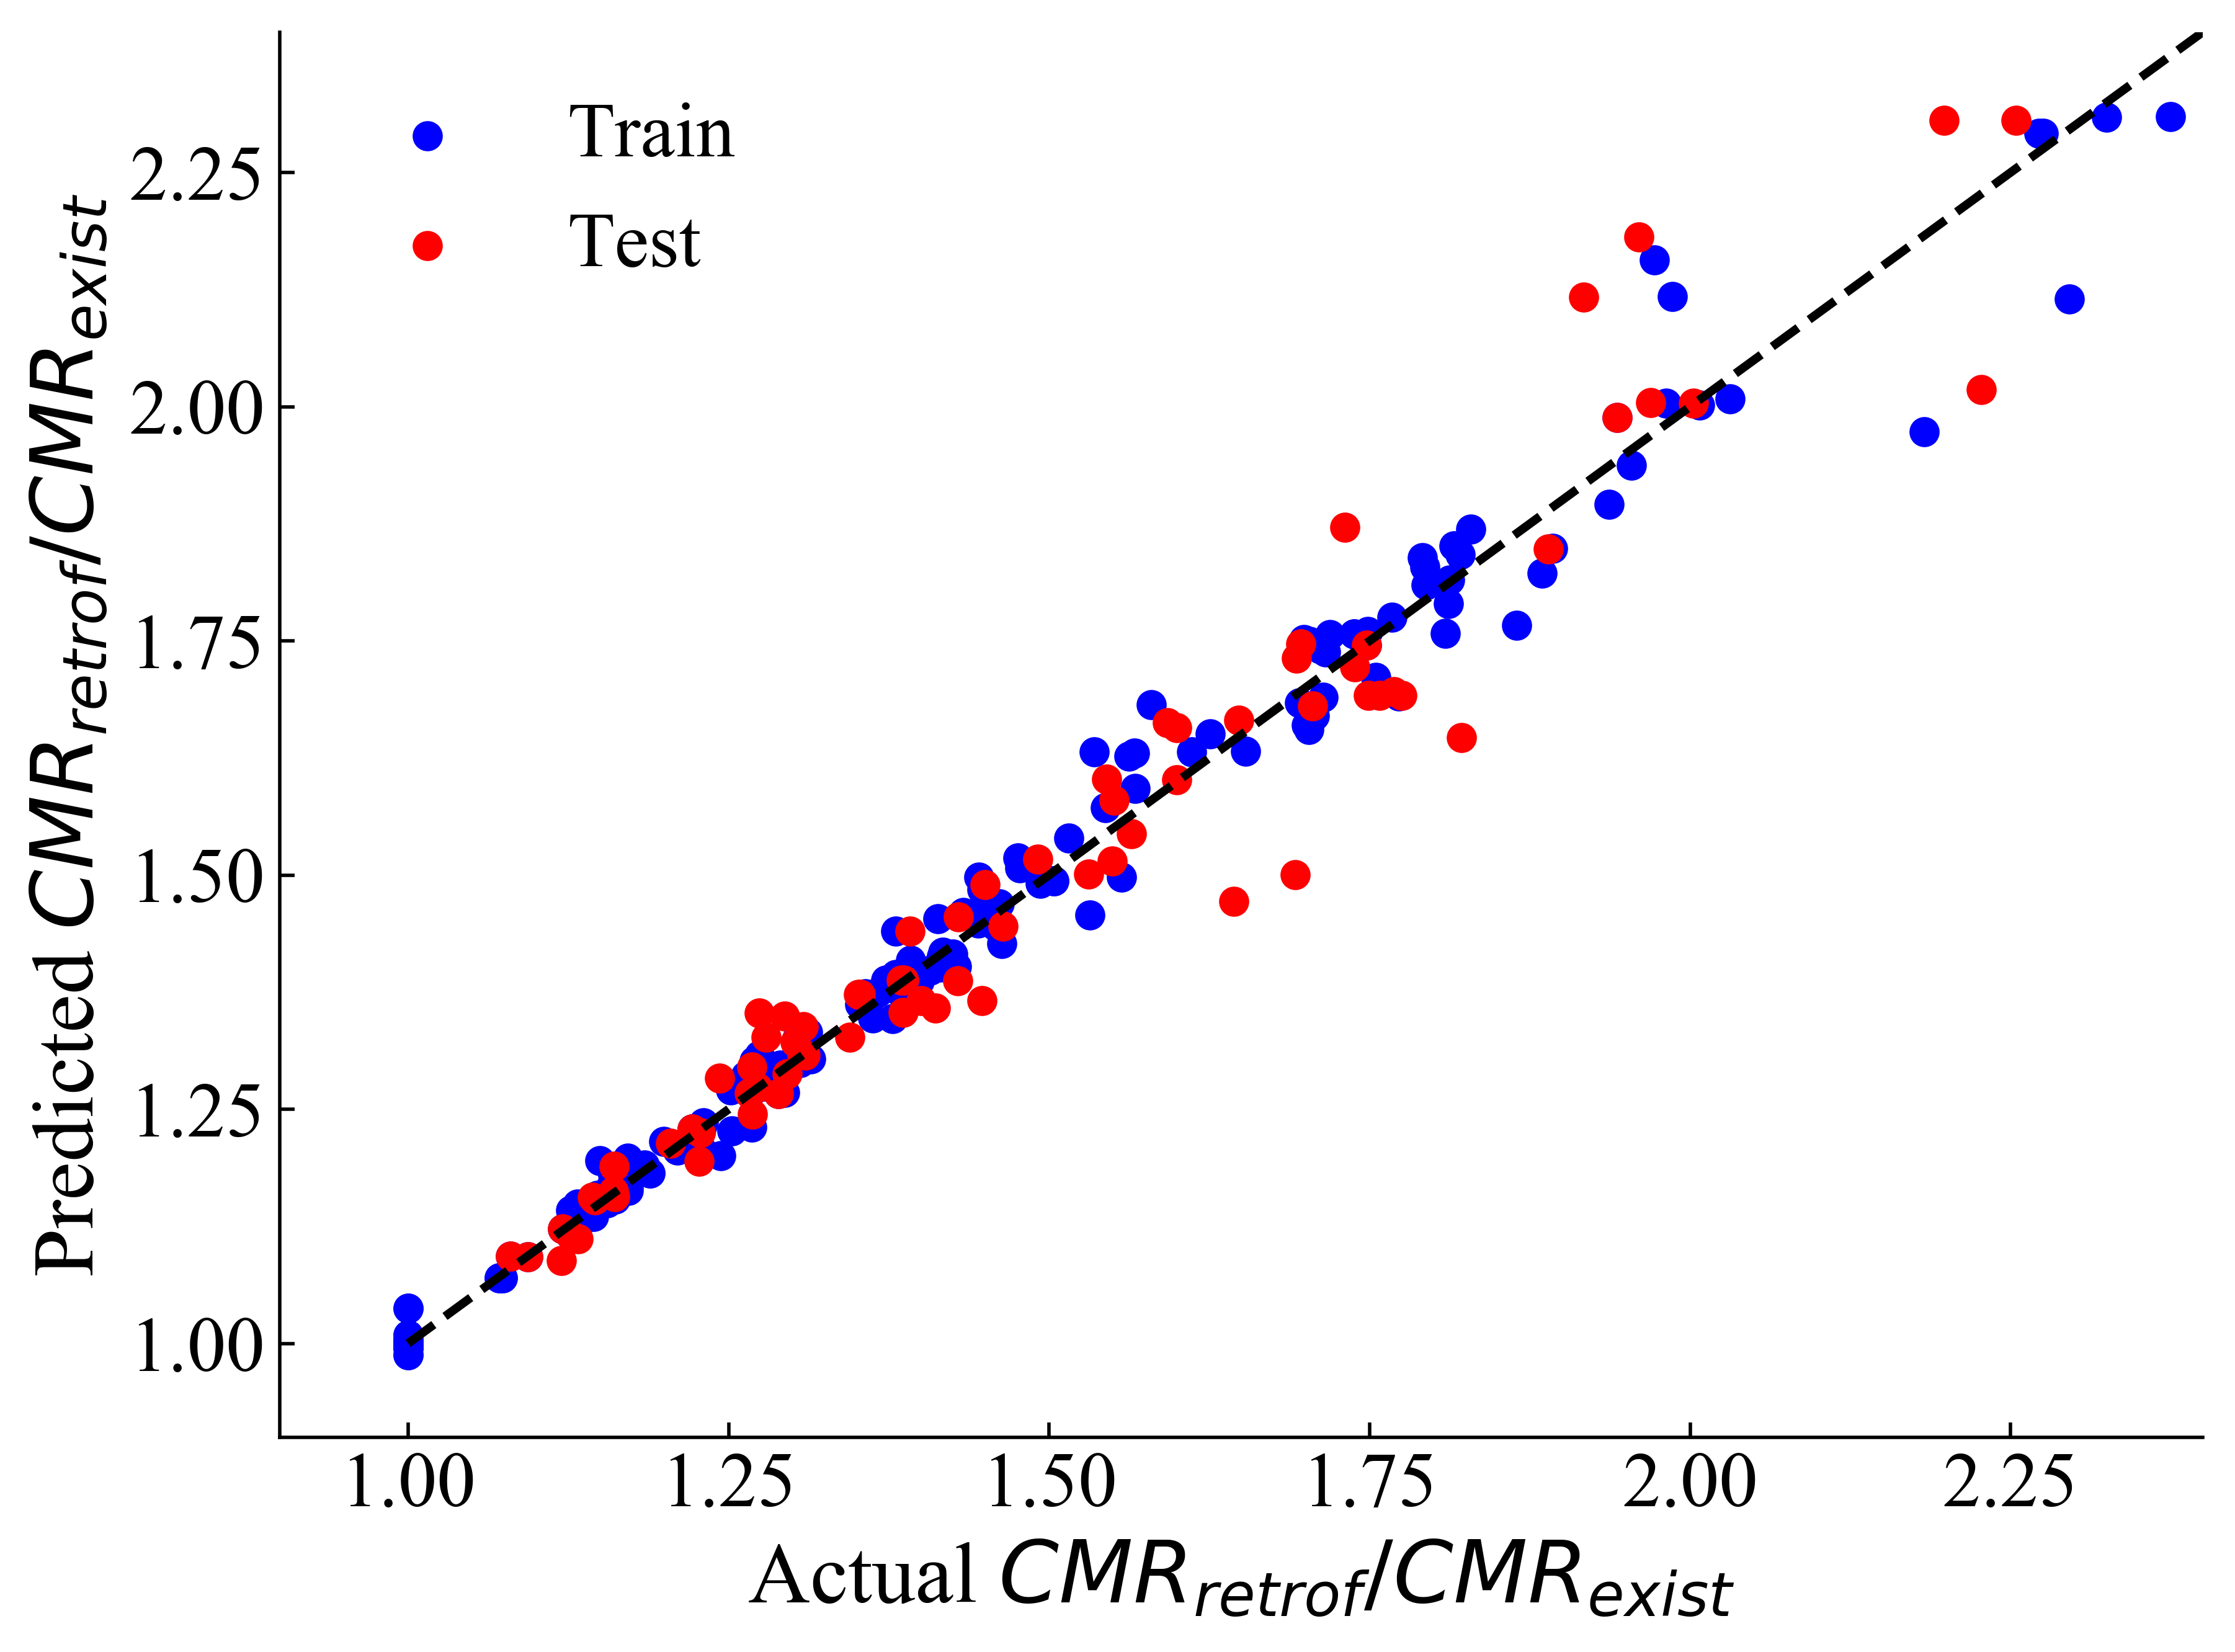

In [9]:
# X_train, X_test, y_train, y_test = train_test_split(Retrofit_TrainTest_DesignMatrix.append(Retrofit_Verification_DesignMatrix), Retrofit_TrainTestDSMedian_Ratio.append(Retrofit_VerificationDSMedian_Ratio) ,test_size = 0.1)

X_train, X_test, y_train, y_test = train_test_split(Retrofit_TrainTest_DesignMatrix, Retrofit_TrainTestDSMedian_Ratio, test_size = 0.3)

X_train = X_train.append(Retrofit_Edge_DesignMatrix)
y_train = y_train.append(Retrofit_EdgeDSMedian_Ratio)

reXGB_Complete = param_randomizedtune_pipline(XGBRegressor(), X_train, X_test, y_train.iloc[:,0], y_test.iloc[:,0], param_grid, plot_flag = True)
reXGB_Complete = reXGB_Complete.best_estimator_

In [21]:
print(reXGB_Complete.feature_importances_)
X_train.head(2)

[0.04365874 0.04214326 0.04578036 0.13620304 0.04528568 0.14555478
 0.09417309 0.         0.         0.0956194  0.35158163]


,NumStory,SeismicWeight,Area,LongDim,ShortDim,LongWall,ShortWall,DampingRatio,StoryHeight,Xpeakstrength,Zpeakstrength
82,3,247.572292,4500,600,360,5832.75,4054.5,0.01,9.25,1.000001,1.583530
113,2,150.971375,3000,600,360,3784.00,2527.5,0.01,9.25,1.000110,1.545671


In [28]:
print(np.divide(np.abs(reXGB_Complete.predict(X_train) - y_train.iloc[:,0]),y_train.iloc[:,0]).mean())
print(np.divide(np.abs(reXGB_Complete.predict(X_test) - y_test.iloc[:,0]),y_test.iloc[:,0]).mean())
print(np.divide(np.abs(reXGB_Complete.predict(Retrofit_Verification_DesignMatrix) - Retrofit_VerificationDSMedian_Ratio.iloc[:,0].values),Retrofit_VerificationDSMedian_Ratio.iloc[:,0].values).mean())

0.02080485063507333
0.06939124162572963
0.04647360369029216


XGBRegressor(alpha=0.4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
       importance_type='gain', lambda=0, learning_rate=0.1,
       max_delta_step=0, max_depth=500, min_child_weight=1, missing=nan,
       n_estimators=100, n_jobs=1, nthread=None, num_feature=15,
       objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=None, silent=None, subsample=0.2,
       verbosity=1)

In [15]:
100*np.divide(np.abs(reXGB_Complete.predict(X_test) - y_test.iloc[:,0]),y_test.iloc[:,0]).mean()

1.4367927195801267

[10:55:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


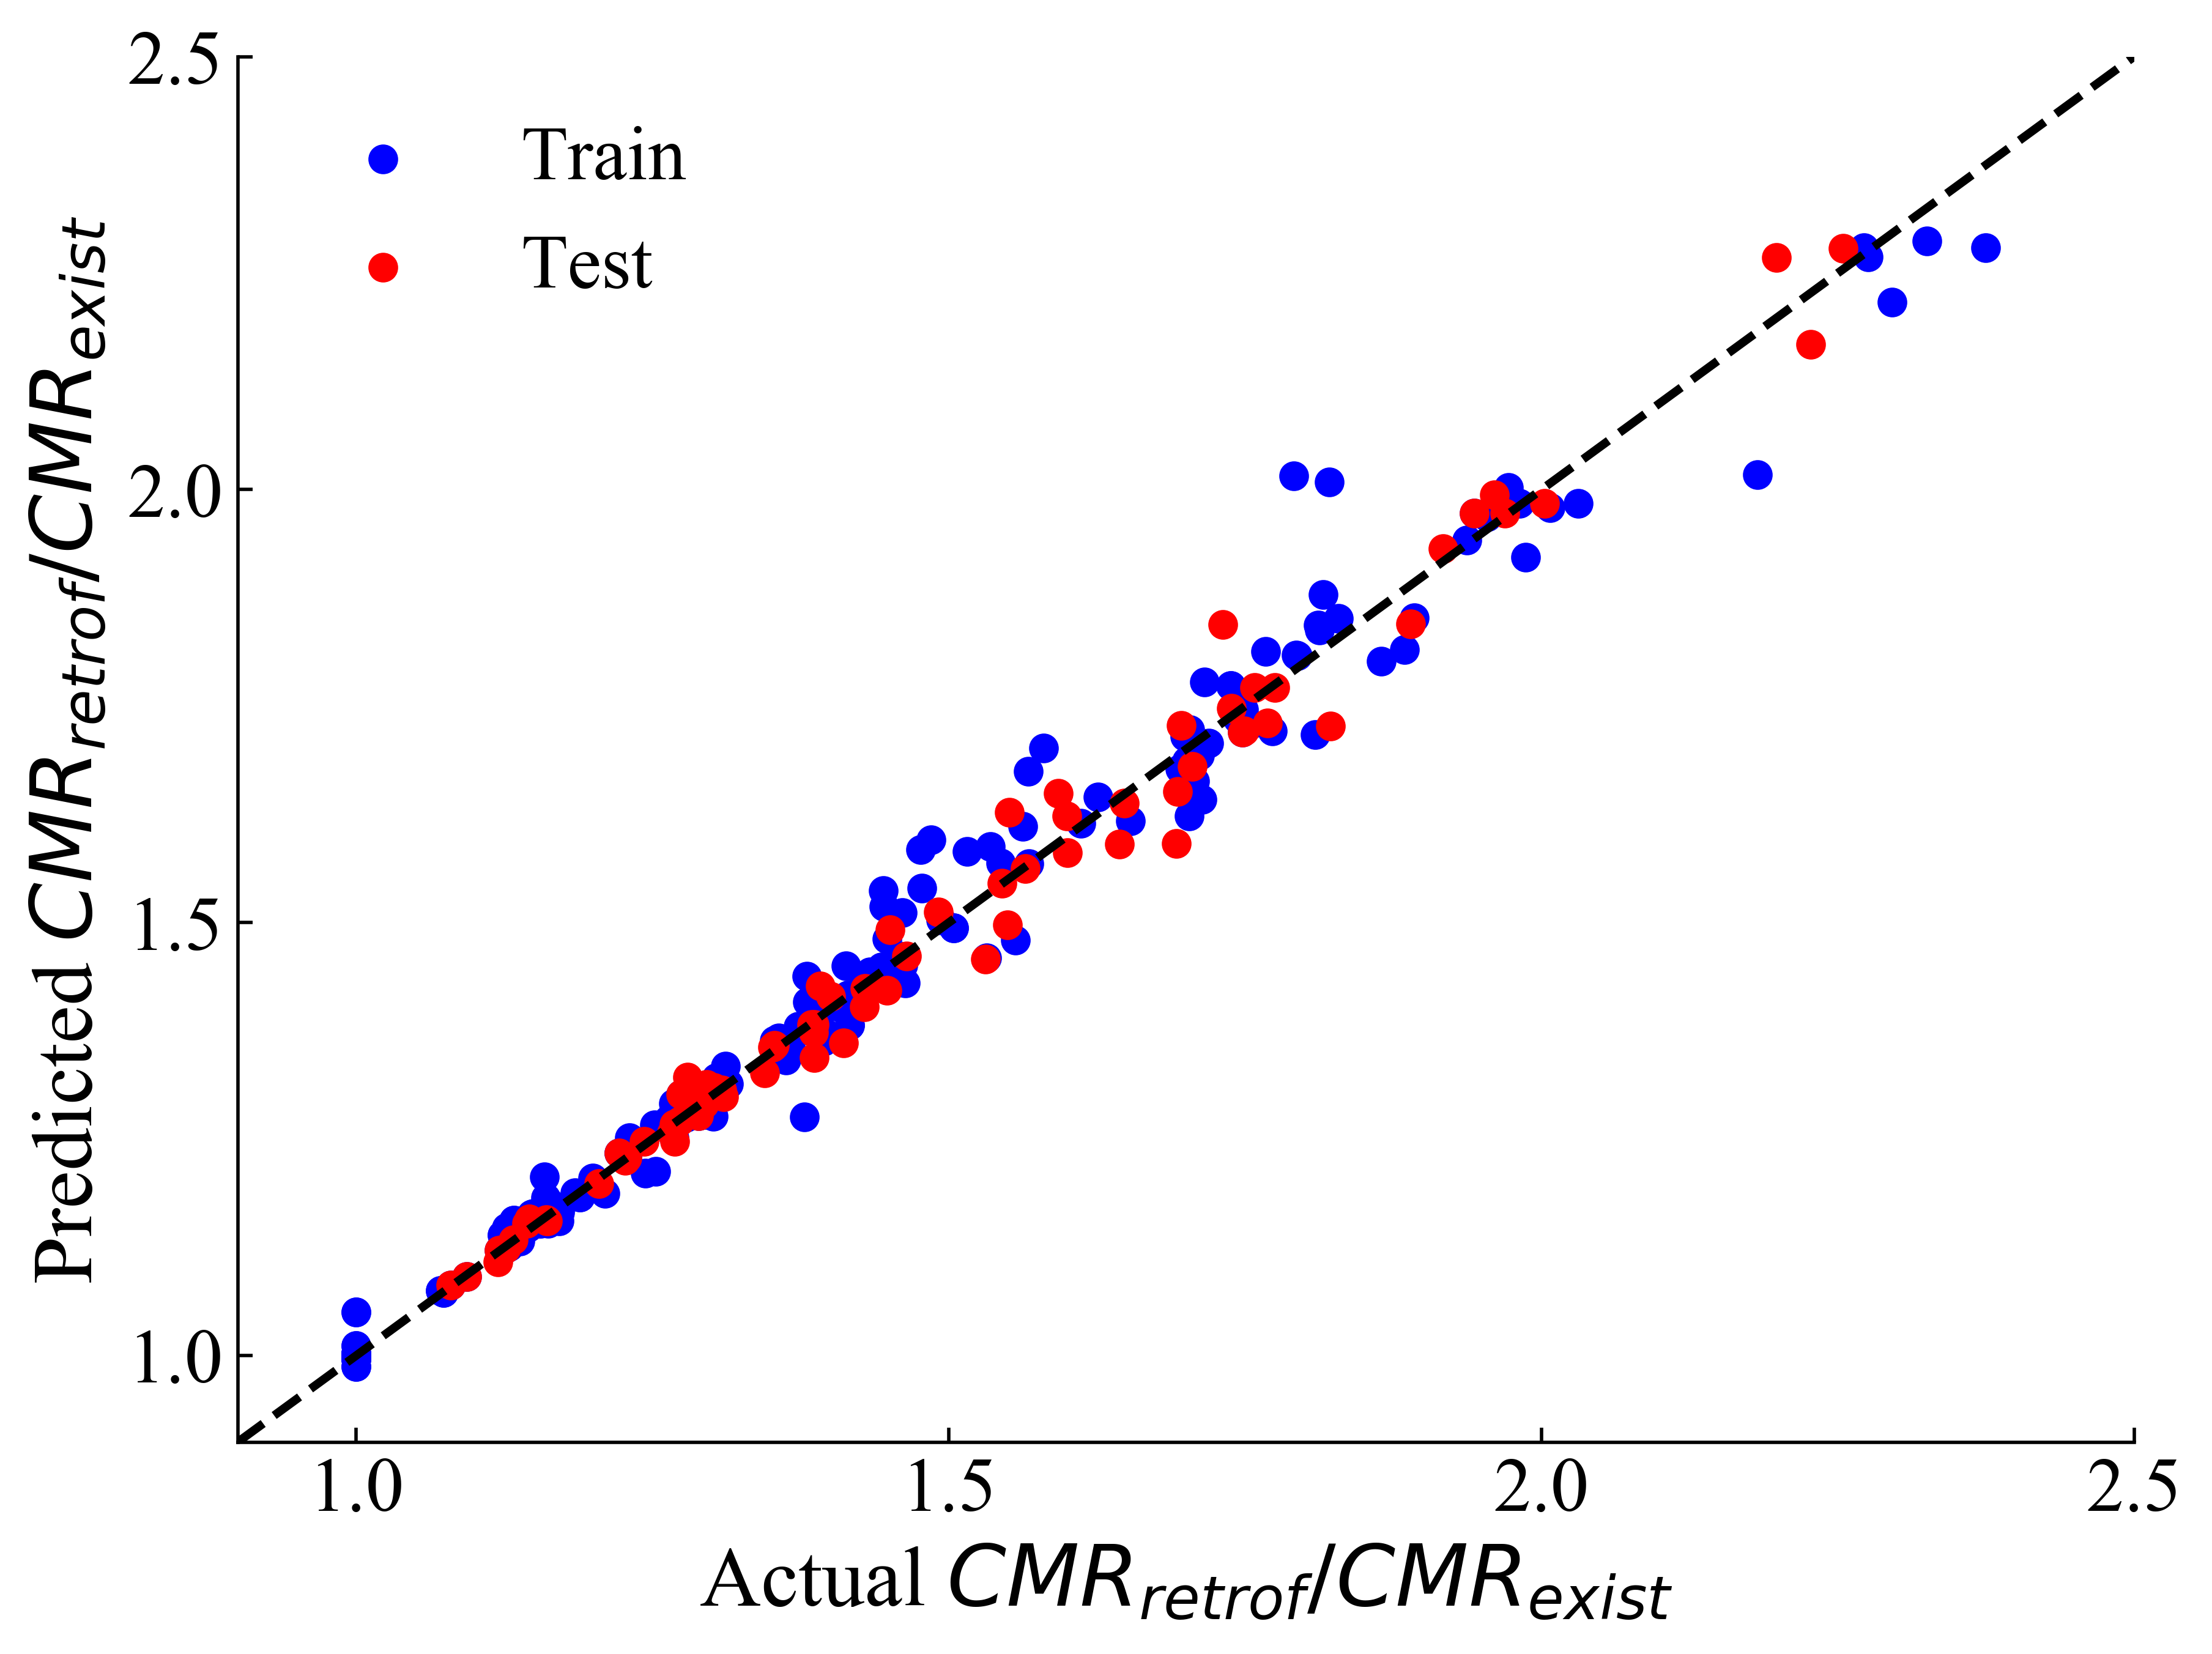

In [12]:
import seaborn as sns
import pickle
os.chdir(r'C:\Users\User\Desktop\FinalOptimization\XGBoostPipline\Models')
reXGB_Complete = pickle.load(open('Retrof_Complete_Ratio.pkl','rb'))

font = {'fontname':'Times New Roman', 'size' : 20}
fig, ax = plt.subplots(figsize=(8,6), dpi=500)
ax.scatter(y_train.iloc[:,0], reXGB_Complete.predict(X_train), color = 'blue', label = 'Train')
ax.scatter(y_test.iloc[:,0], reXGB_Complete.predict(X_test), color = 'red', label = 'Test')
# ax.scatter(Retrofit_VerificationDSMedian_Ratio,reXGB_Complete.predict(Retrofit_Verification_DesignMatrix) , color = 'green', label = 'Actual Ordinance Design')

ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
# plt.plot([y_train.min(), y_train.max()],[y_train.min(), y_train.max()], color = 'black', linewidth = 2)
plt.xlim([0.9,2.5])
plt.xticks( fontname = 'Times New Roman', fontsize = 18)
plt.ylim([0.9,2.5])
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.yticks(fontname = 'Times New Roman', fontsize = 18)
plt.xlabel('Actual $CMR_{retrof} / CMR_{exist}$', **font)
plt.ylabel('Predicted $CMR_{retrof} / CMR_{exist}$', **font)
plt.legend(frameon = False, prop =  {"family":'Times New Roman', "size":18})
plt.plot([0.9,6],[0.9,6],'--', linewidth = 2, color = 'black')
sns.despine()

In [29]:
mc_ratio = []
added_strength = []

os.chdir(r'C:\Users\User\Desktop\FinalOptimization\Optimization_AllArchetypes')
# Read existing building damage state
existing_ds = pd.read_csv('building_ds.csv')

# Read existing building properties and pushover 
existing_prop = pd.read_csv('existing_property.csv')

# Read missing strength
missing_strength = pd.read_csv('building_miss_strength.csv')

for k in range(32):

    prop = existing_prop.iloc[k,:]
    x_strength, z_strength = prop['SeismicWeight']*prop['Xpeakstrength'], prop['SeismicWeight']*prop['Zpeakstrength']

    temp1 = []
    temp2 = []
    for i in range(1, 21):
        prop['Xpeakstrength'] = 1 + i*0.05
        prop['Zpeakstrength'] = 1 + i*0.05
        temp = pd.DataFrame(columns=['NumStory', 'SeismicWeight','Area','LongDim','ShortDim','LongWall','ShortWall','DampingRatio','StoryHeight','Xpeakstrength', 'Zpeakstrength'], index=range(1))
        temp.iloc[0,:] = prop.values[1:]
        temp1.append(reXGB_Complete.predict(temp.astype('float')))
        temp2.append(i*x_strength*0.05 + i*z_strength*0.05)

    mc_ratio.append([x[0] for x in temp1])
    added_strength.append(temp2)

No handles with labels found to put in legend.


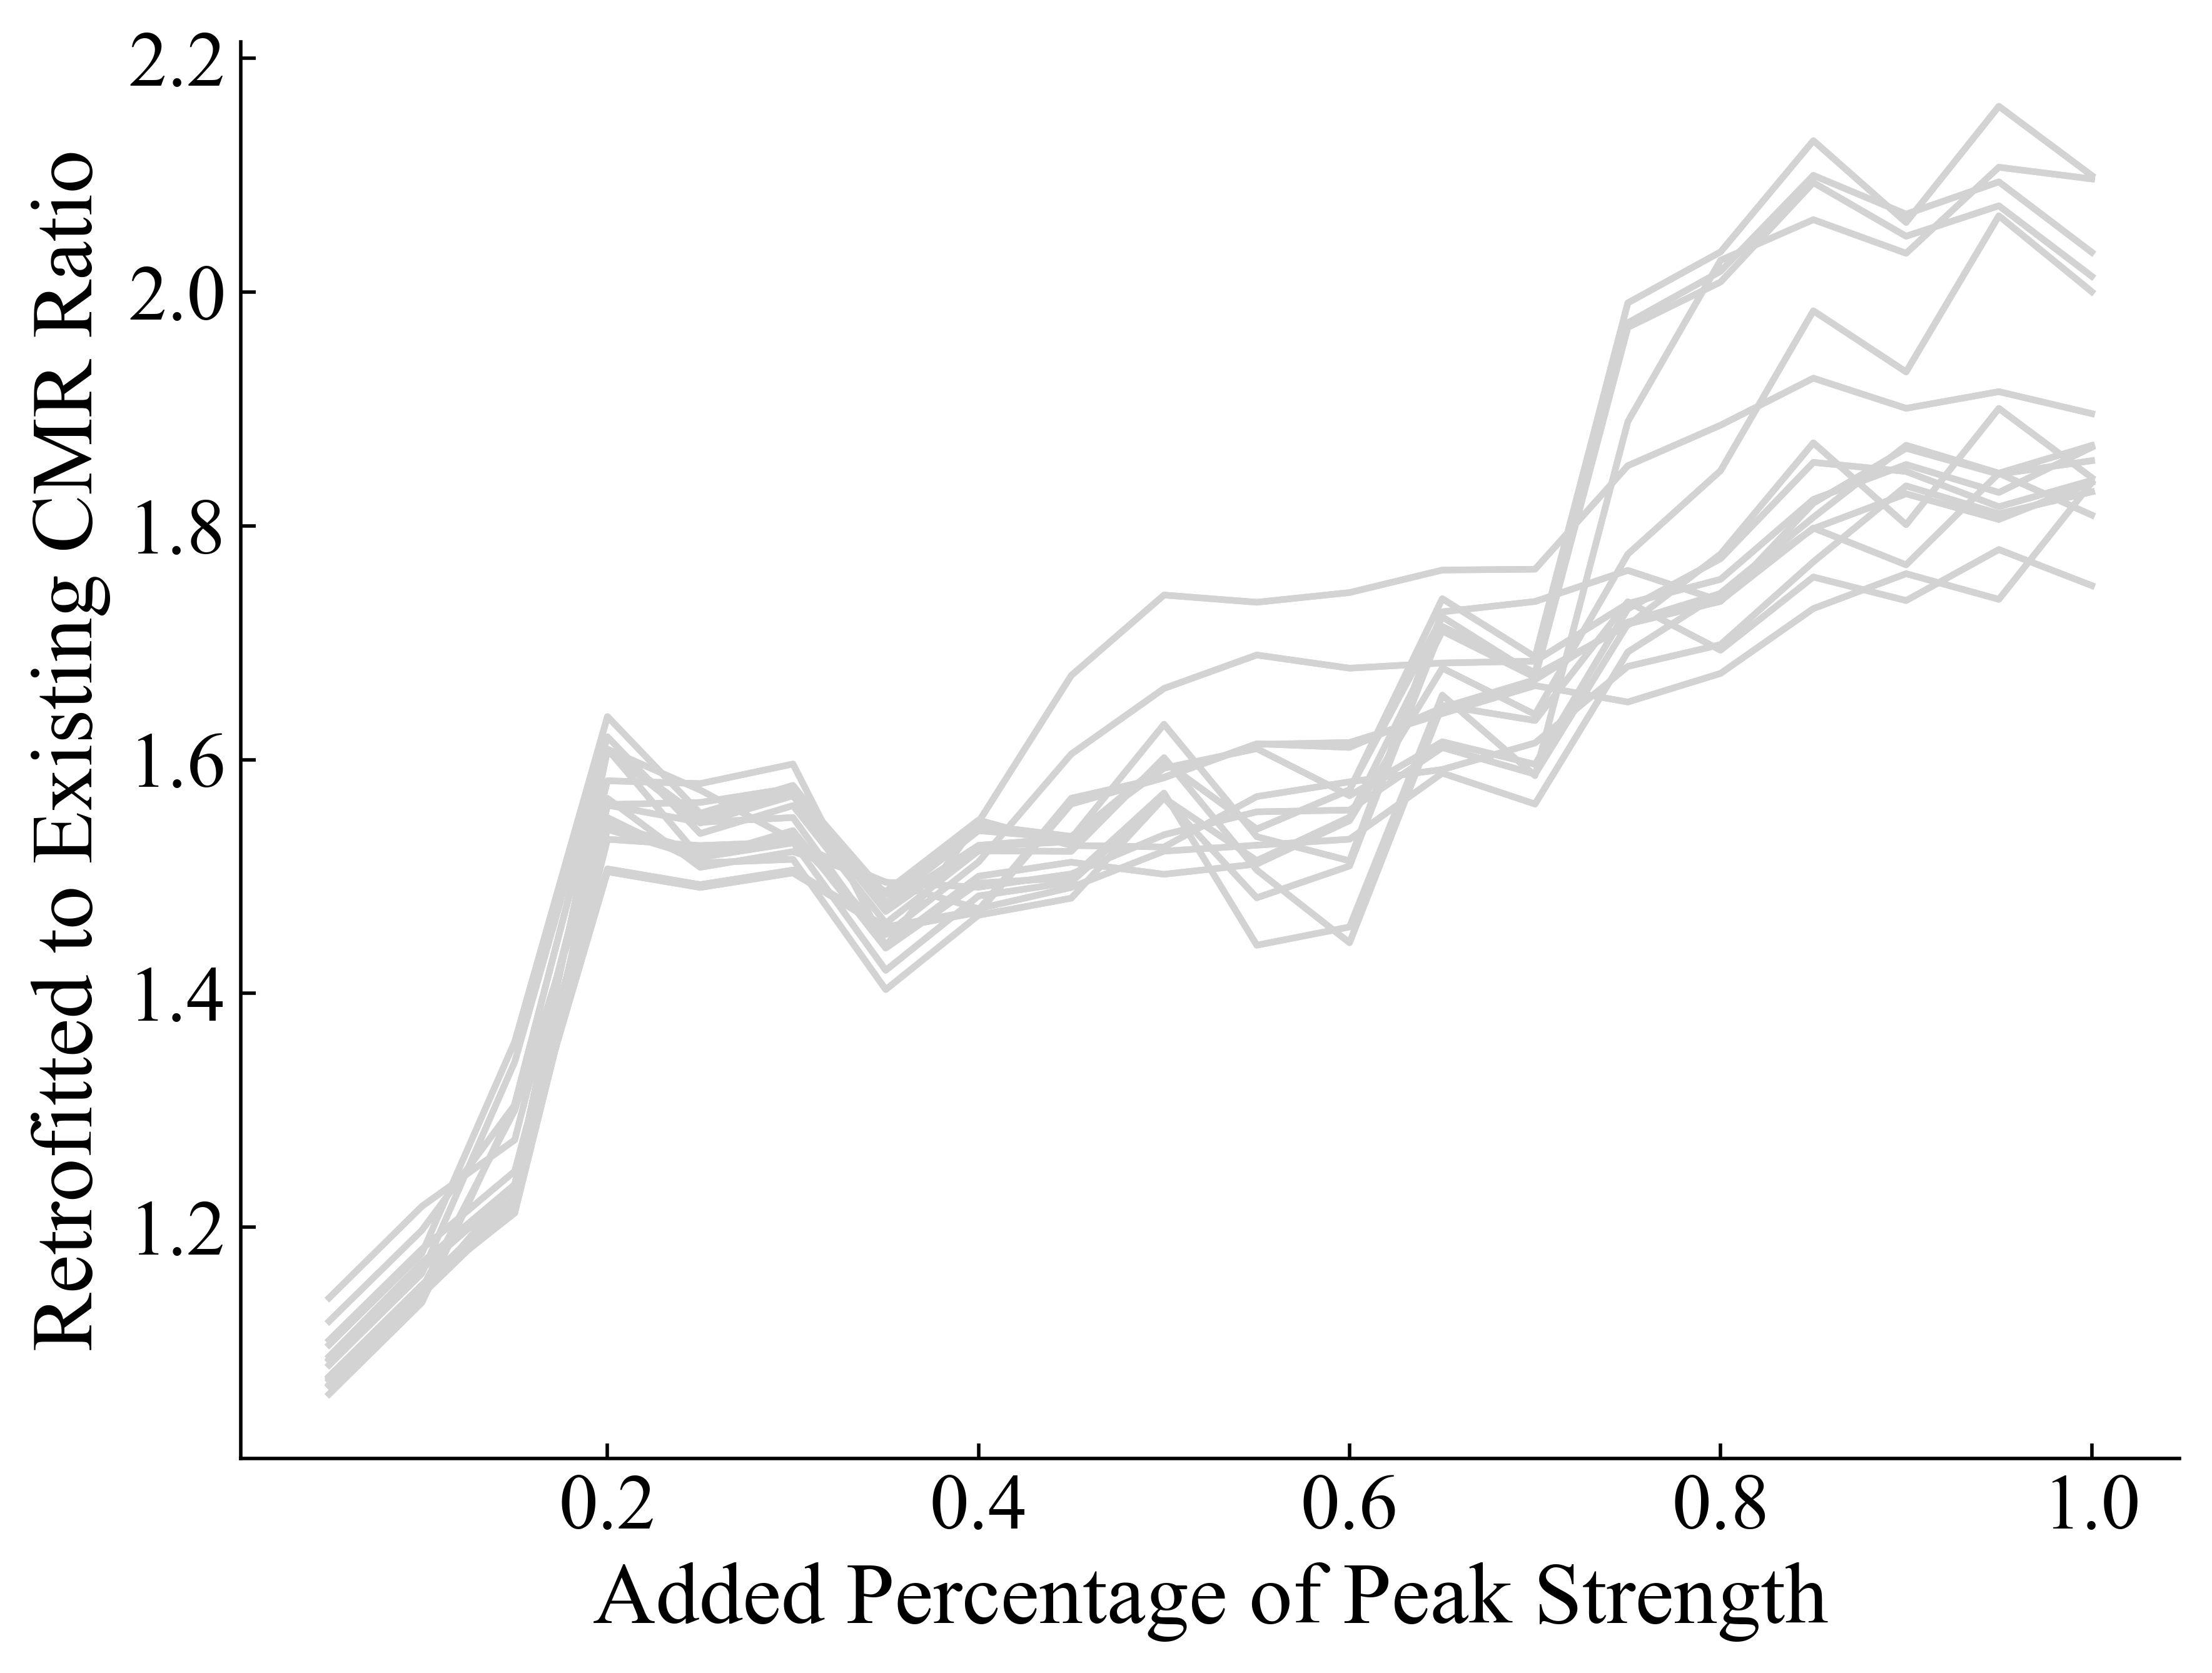

In [30]:
# for k in range(32):
#     plt.plot(np.multiply(range(1, 21),0.05), np.divide(mc_ratio[k],added_strength[k]) , color = 'grey')
font = {'fontname':'Times New Roman', 'size' : 20}
fig, ax = plt.subplots(figsize=(8,6), dpi=500)
for k in range(32):
    plt.plot(np.multiply(range(1, 21),0.05), mc_ratio[k], color = 'lightgrey')
    # plt.plot(added_strength[k] , mc_ratio[k], color = 'lightgrey')

ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
plt.xticks( fontname = 'Times New Roman', fontsize = 18)
plt.yticks(fontname = 'Times New Roman', fontsize = 18)
plt.xlabel('Added Percentage of Peak Strength', **font)
plt.ylabel('Retrofitted to Existing CMR Ratio', **font)
plt.legend(frameon = False, prop =  {"family":'Times New Roman', "size":18})
# plt.plot([1,6],[1,6],'--', linewidth = 2, color = 'black')
sns.despine()

In [51]:
X_train.head()

,NumStory,SeismicWeight,Area,LongDim,ShortDim,LongWall,ShortWall,DampingRatio,StoryHeight,Xpeakstrength,Zpeakstrength
1052,3,296.023,1500,600,360,5832.75,4054.5,0.010,9.406417,1.575309,1.940695
1183,3,551.207,2400,960,360,9383.25,6945.0,0.047,11.696750,1.050522,1.134312
1590,3,1012.040,5000,1200,600,11972.25,11319.0,0.035,11.367920,1.591736,1.725846
443,2,337.152,3000,720,600,6177.00,4857.5,0.042,9.845750,1.285955,1.875178
568,3,887.846,5000,1200,600,12142.50,10036.0,0.026,10.112170,0.951609,1.603085


0.24807697591187589


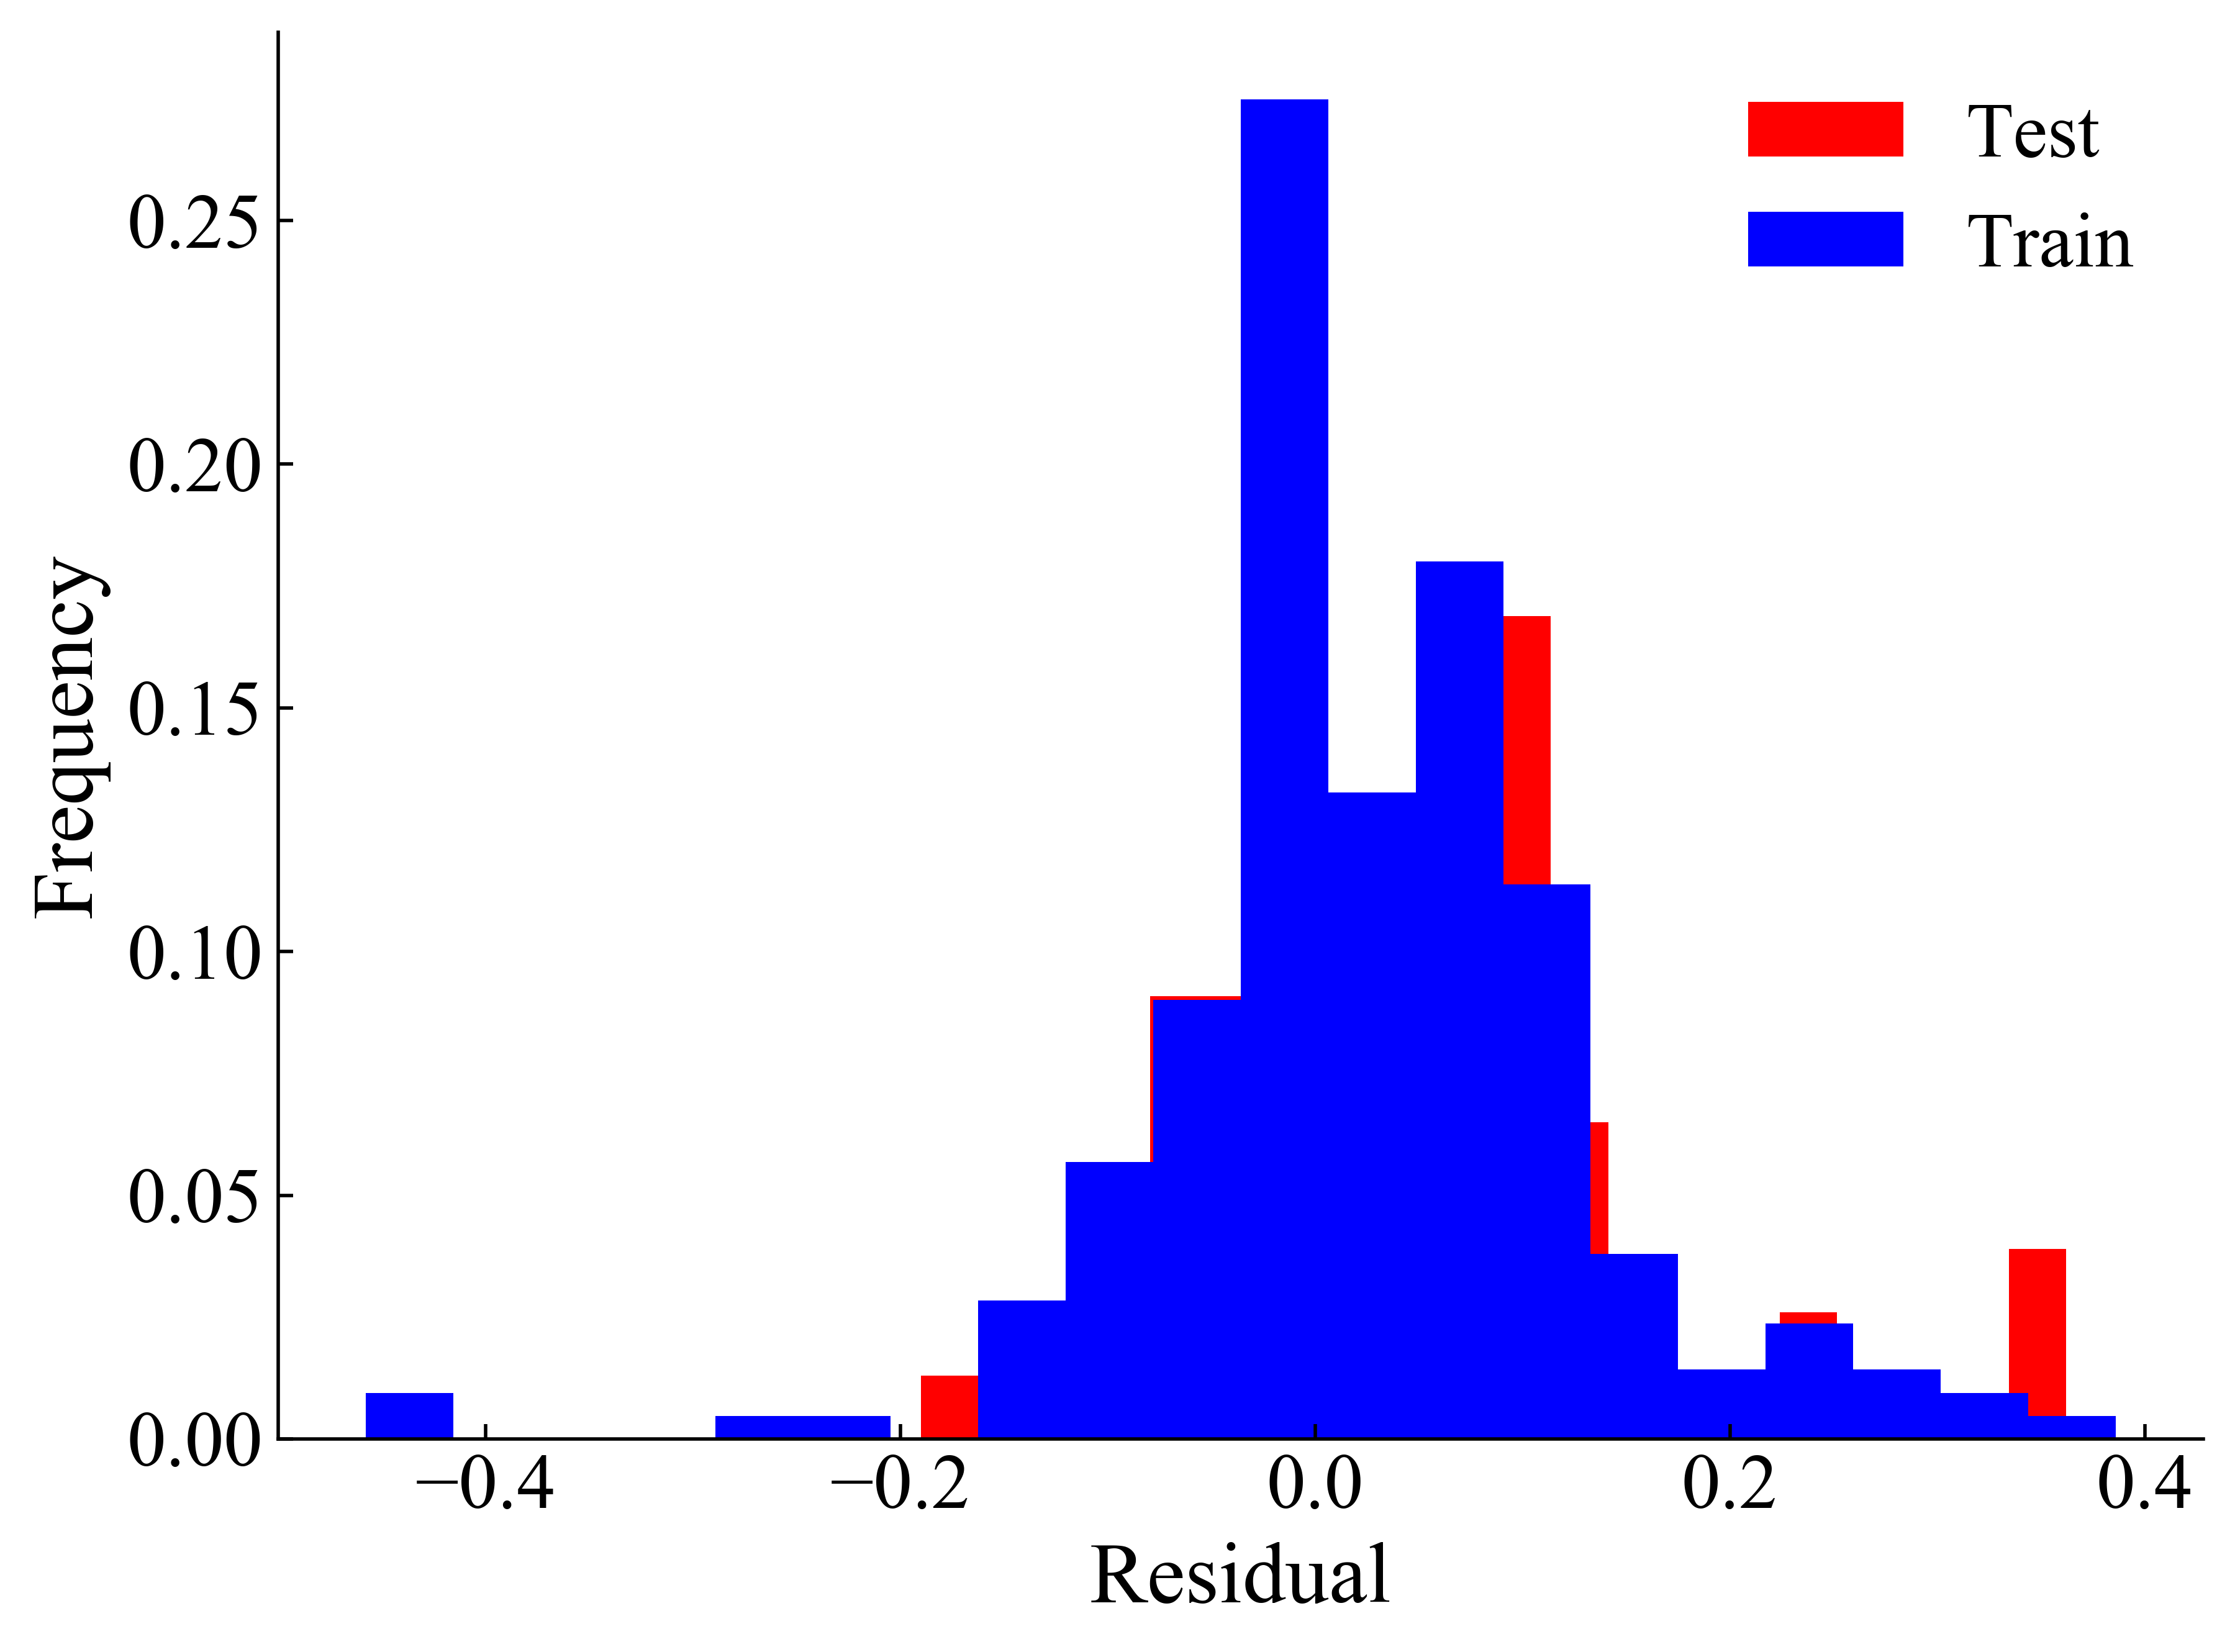

In [28]:
train_resid = reXGB_Complete.predict(X_train)-y_train.iloc[:,0]
test_resid = reXGB_Complete.predict(X_test) - y_test.iloc[:,0]
print(np.mean(test_resid)+2*np.std(test_resid))
font = {'fontname':'Times New Roman', 'size' : 20}
fig, ax = plt.subplots(figsize=(8,6), dpi=500)
ax.hist(test_resid,bins=20, weights = np.ones_like(test_resid)/float(len(test_resid)), label='Test', color='red')
ax.hist(train_resid,bins=20, weights = np.ones_like(train_resid)/float(len(train_resid)), label='Train', color='blue')
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
plt.xticks( fontname = 'Times New Roman', fontsize = 18)
plt.yticks(fontname = 'Times New Roman', fontsize = 18)
plt.locator_params(axis='y', nbins=6)
plt.xlabel('Residual', **font)
plt.ylabel('Frequency', **font)
plt.legend(frameon = False, prop =  {"family":'Times New Roman', "size":18})
sns.despine()

In [11]:
import pickle
os.chdir(r'C:\Users\User\Desktop\FinalOptimization\XGBoostPipline\Models')
with open('Retrof_Complete_Ratio.pkl', 'wb') as file:
    pickle.dump(reXGB_Complete.best_estimator_, file)